Results for year: 2020
MSE: 594.7126255194438
RMSE: 24.386730521319247
MAE: 6.830784334300023
R2 Score: -1.0822037570959862
Average Daily Cases for 2020: 14.86


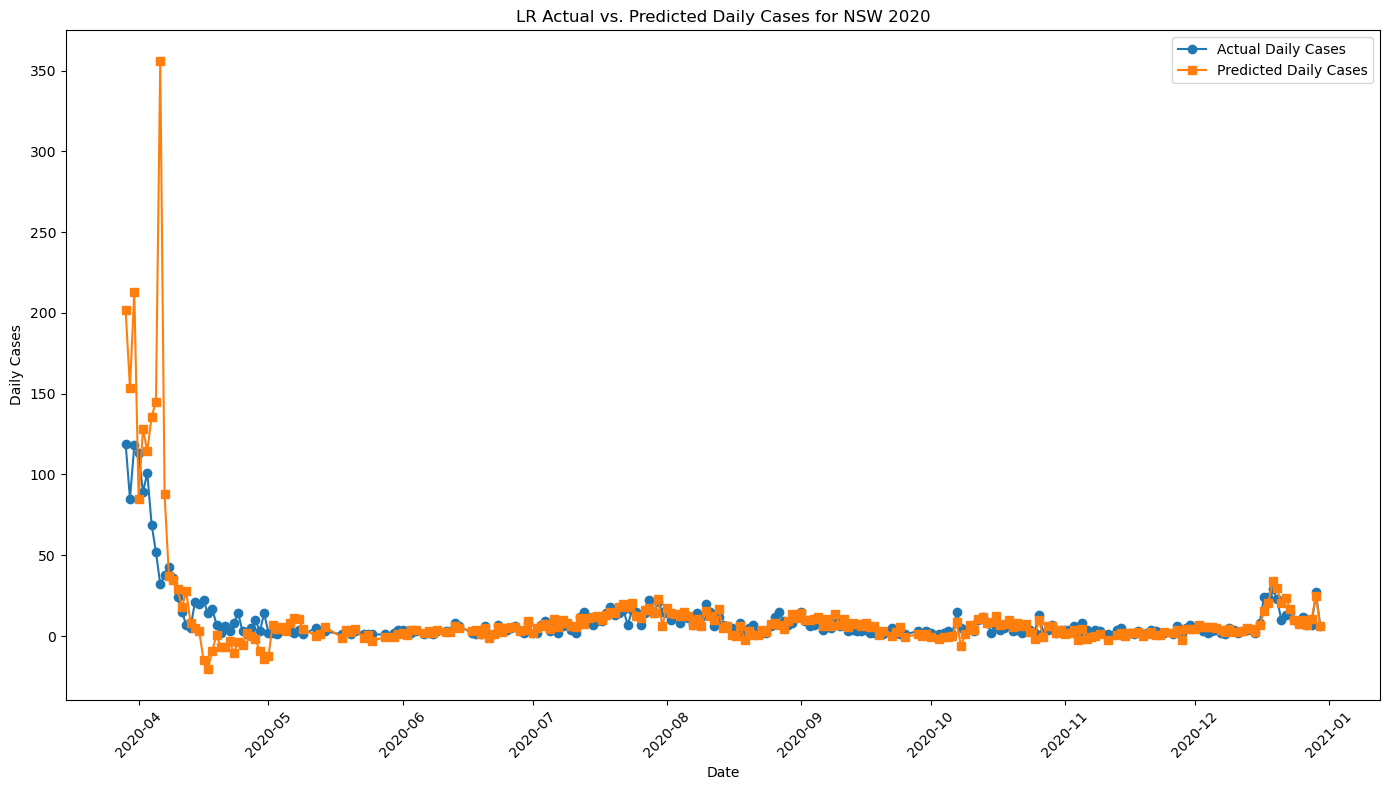

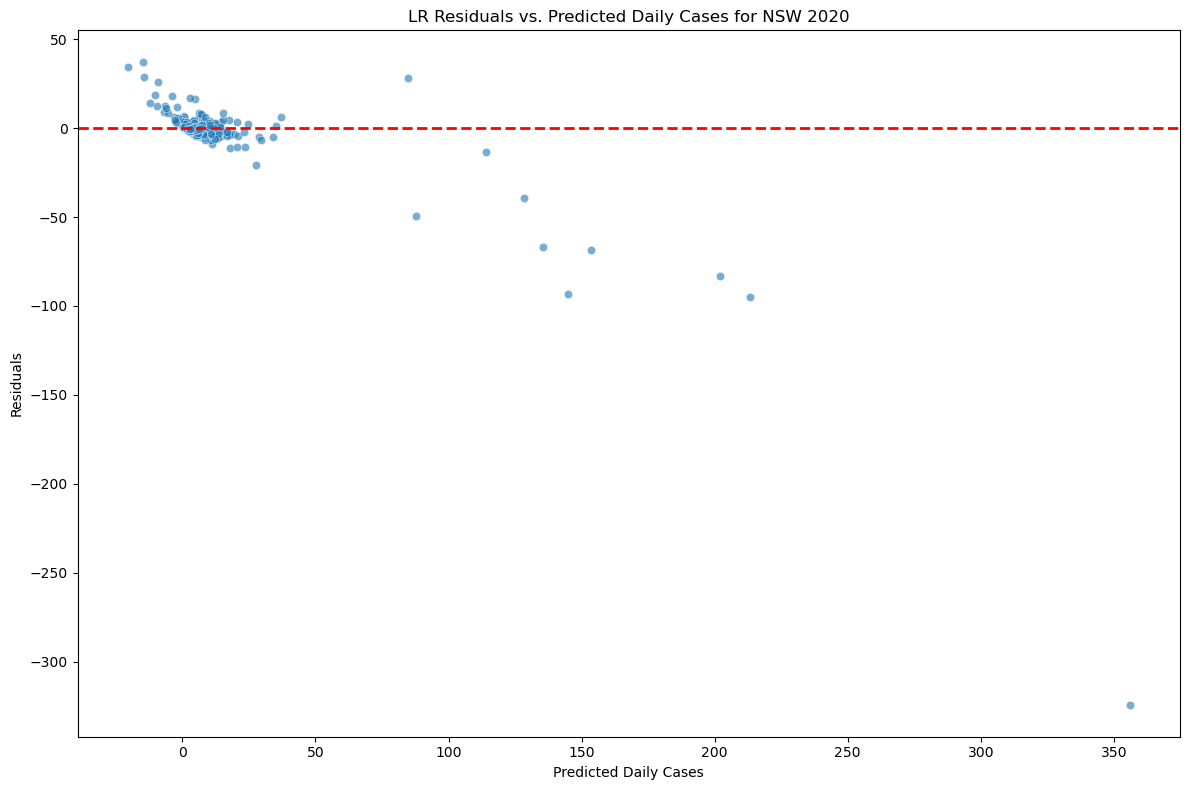

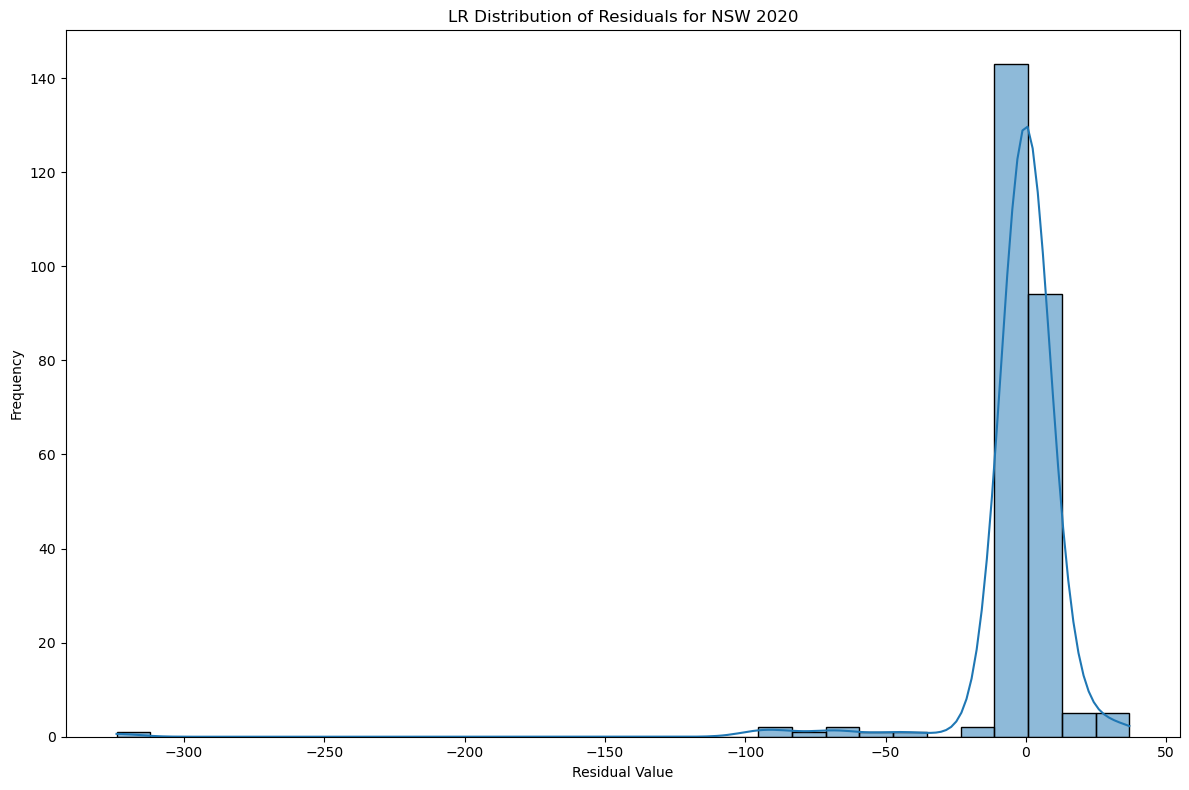

Results for year: 2021
MSE: 203213.6000249779
RMSE: 450.7921916193513
MAE: 94.73692528937124
R2 Score: 0.9448842538997638
Average Daily Cases for 2021: 628.41


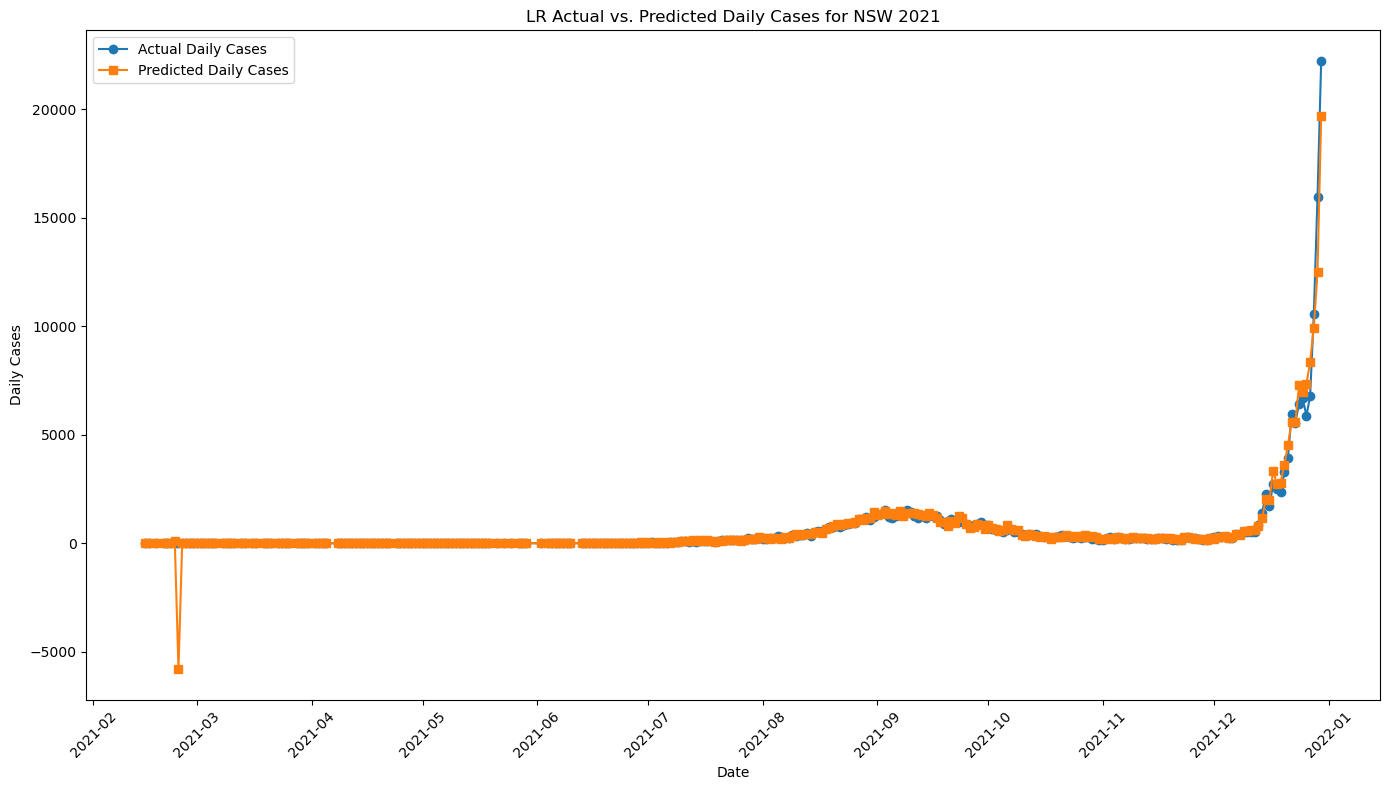

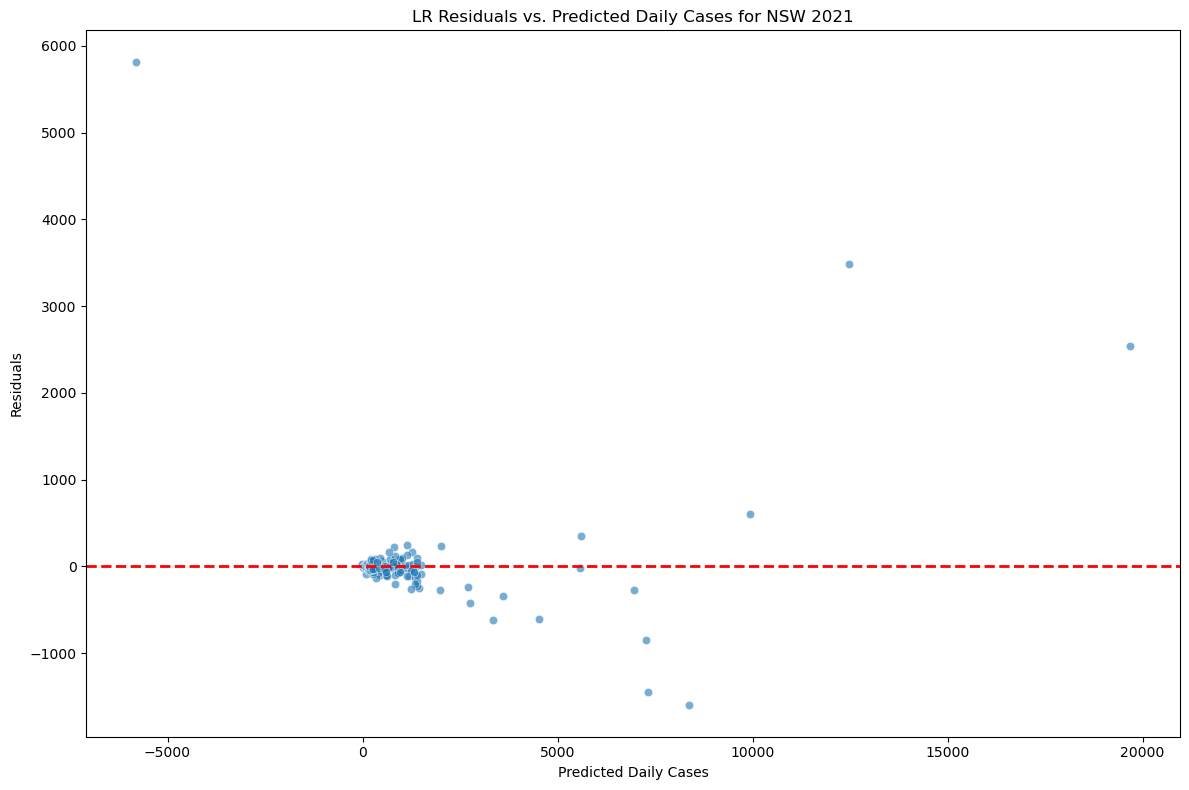

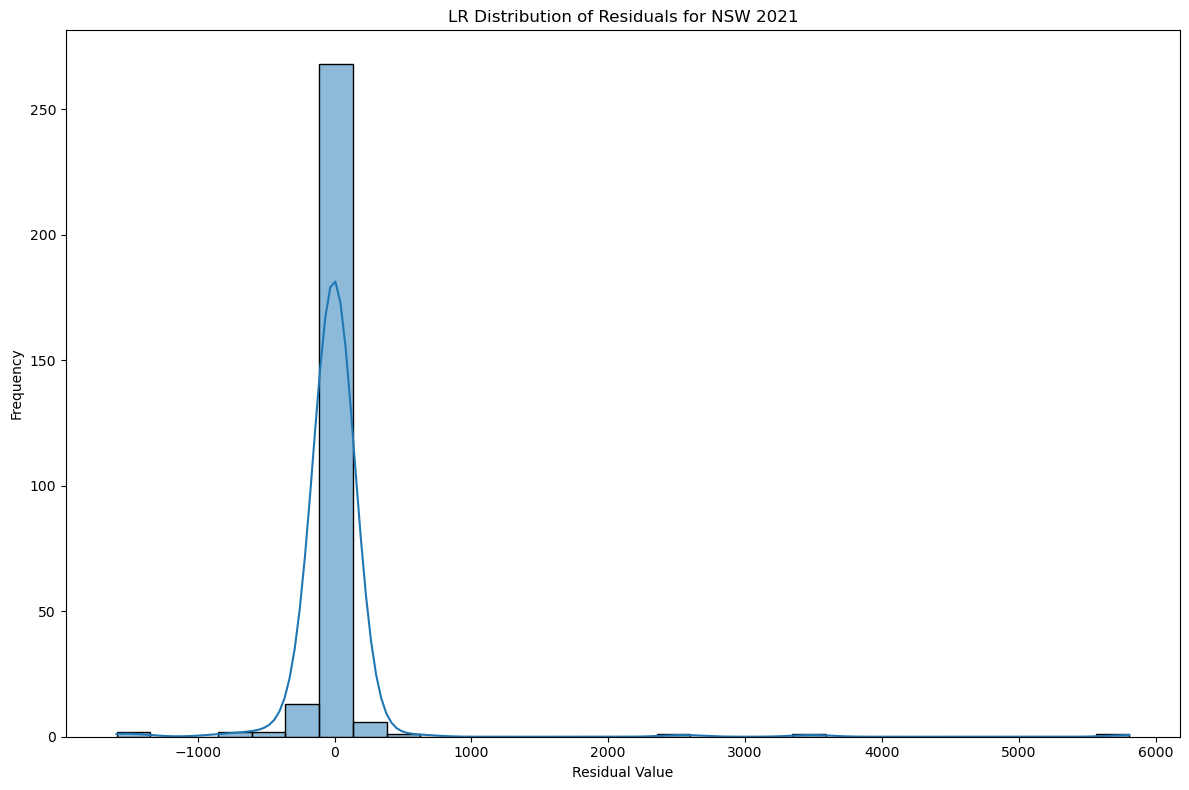

Results for year: 2022
MSE: 26559429.547172297
RMSE: 5153.584145735112
MAE: 1572.967963607774
R2 Score: 0.08714051592822669
Average Daily Cases for 2022: 9328.07


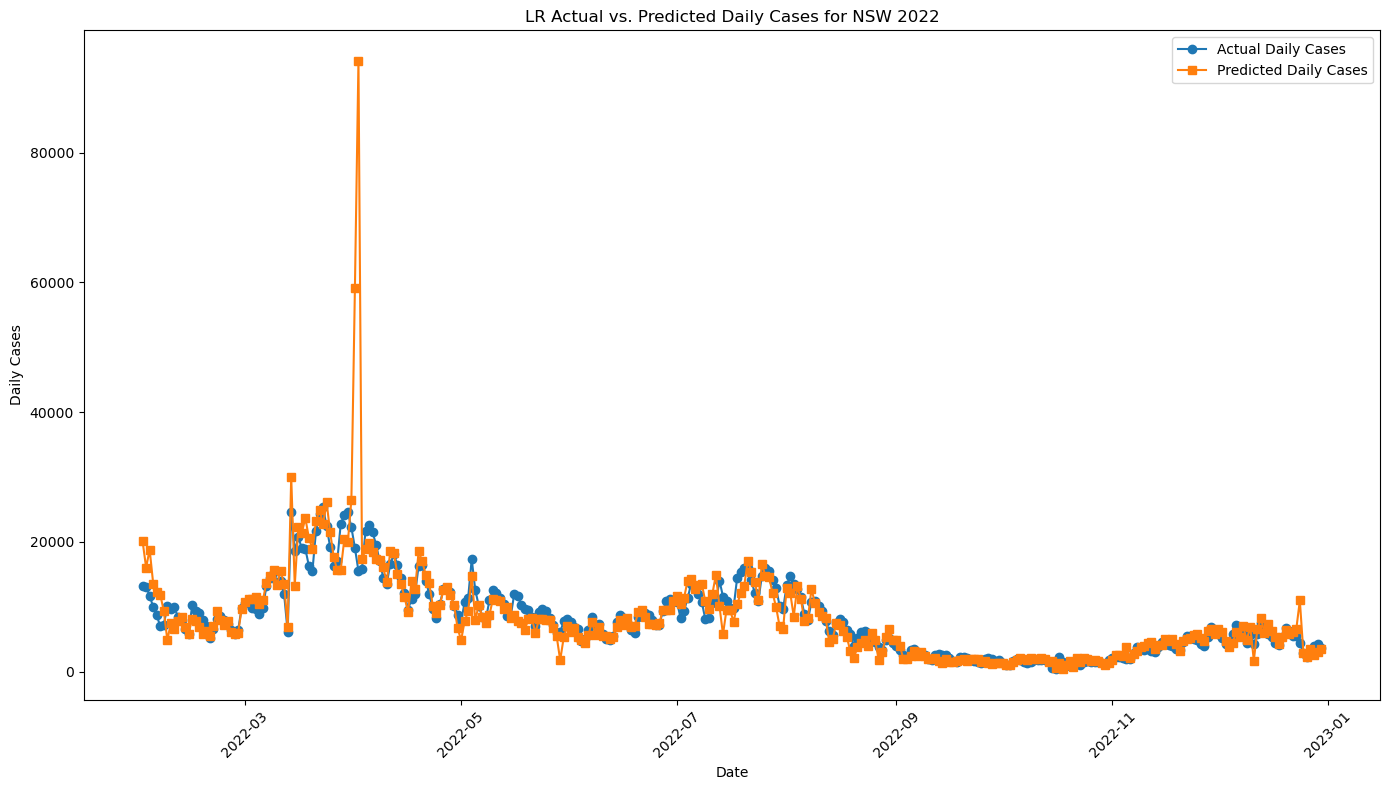

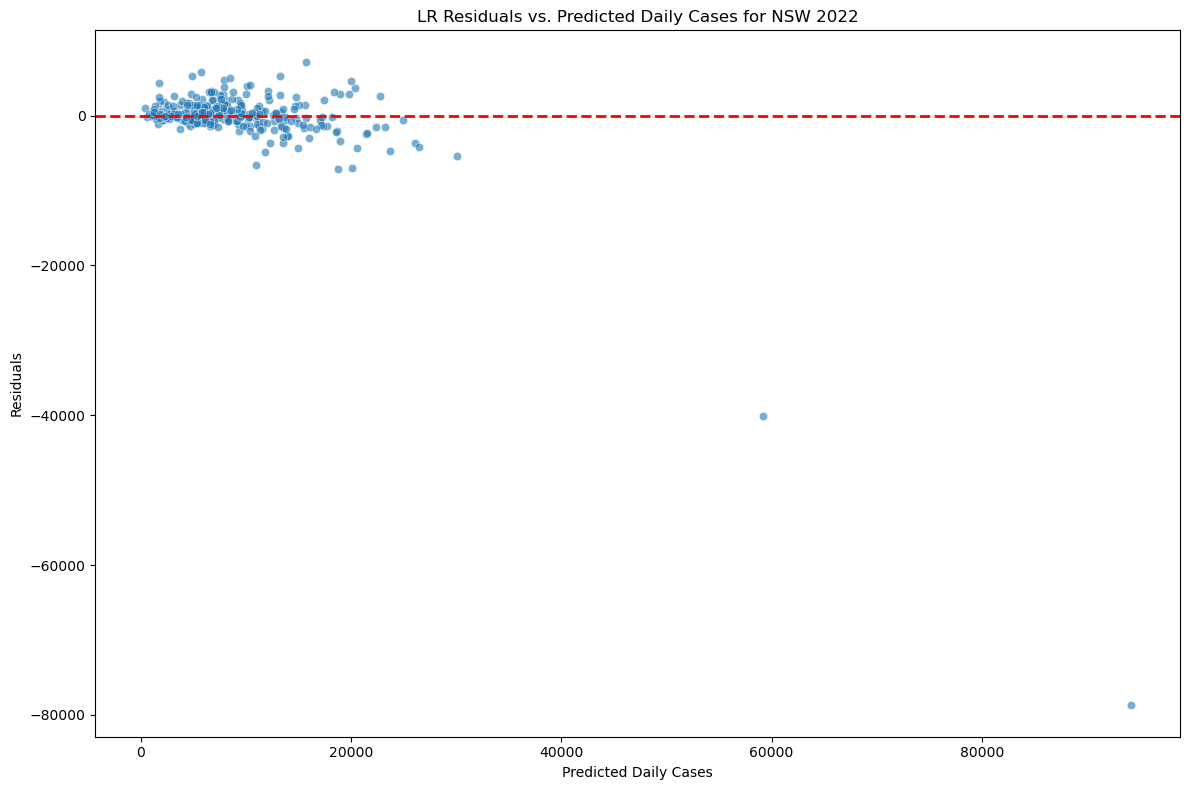

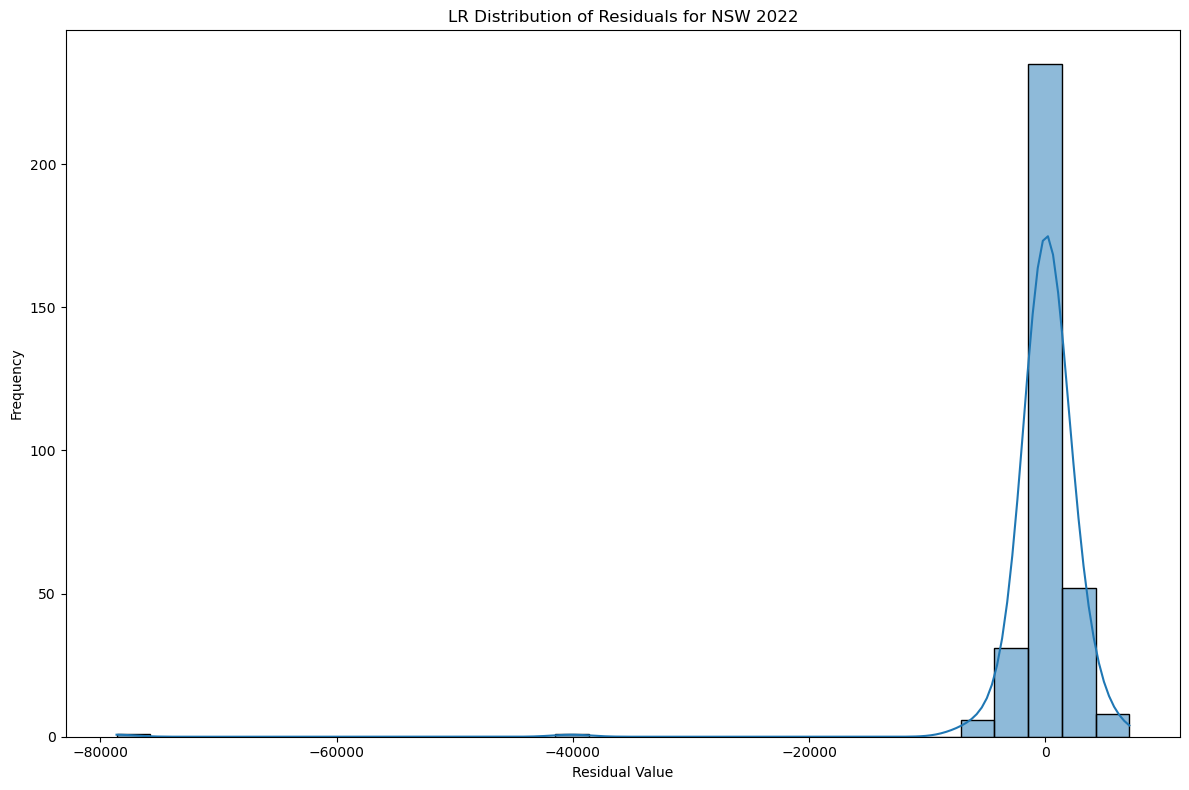

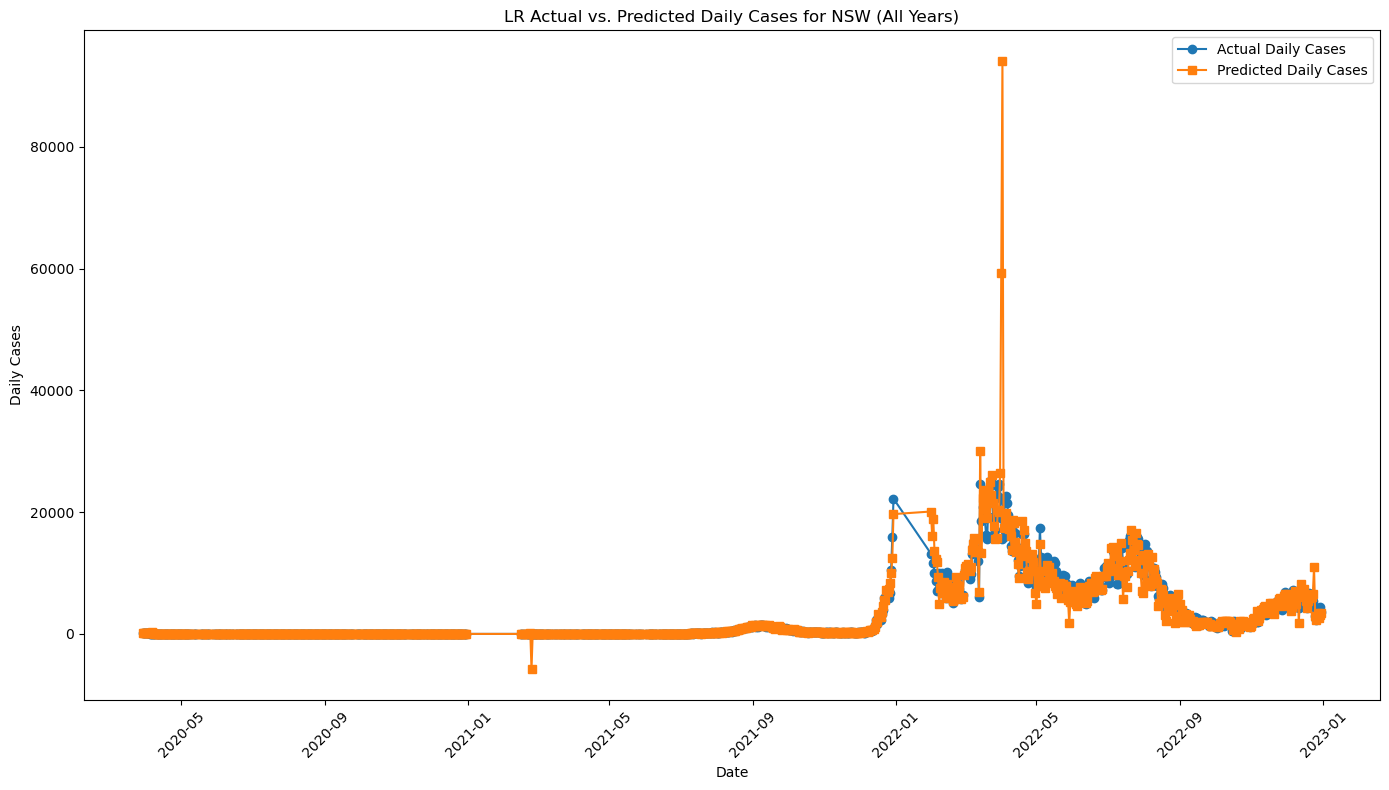

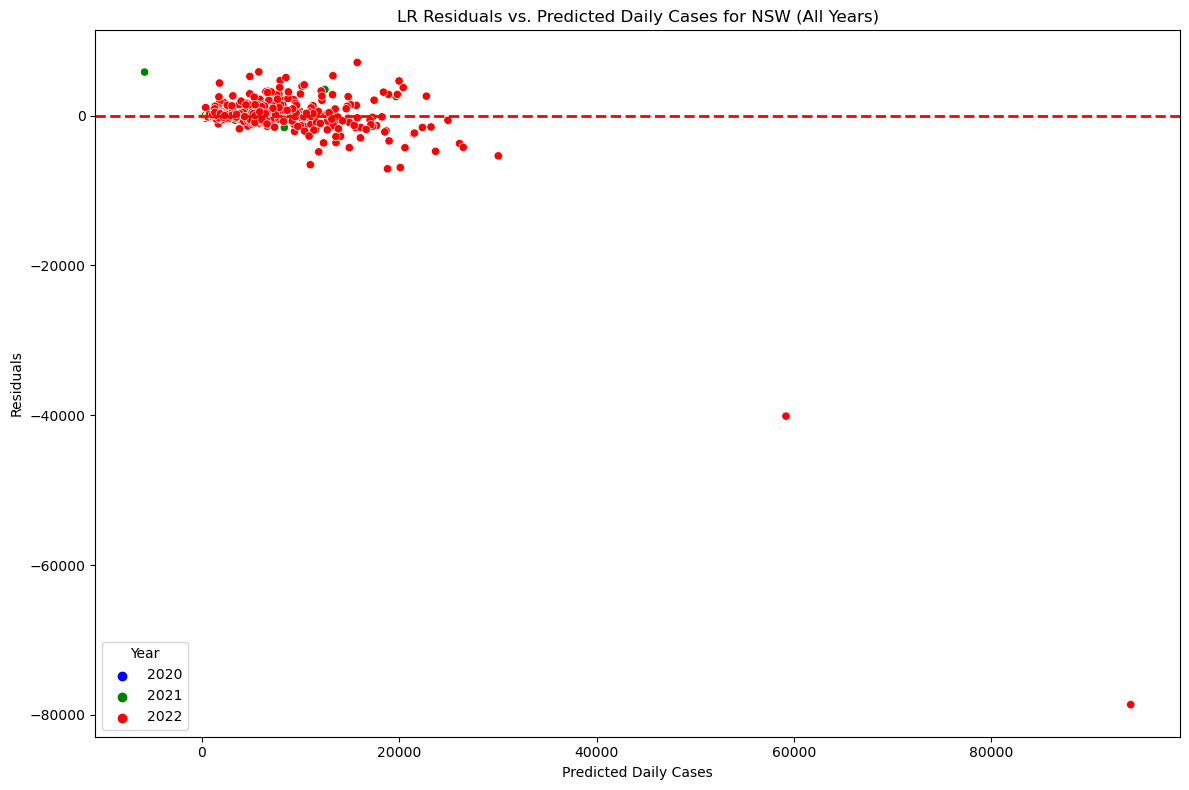

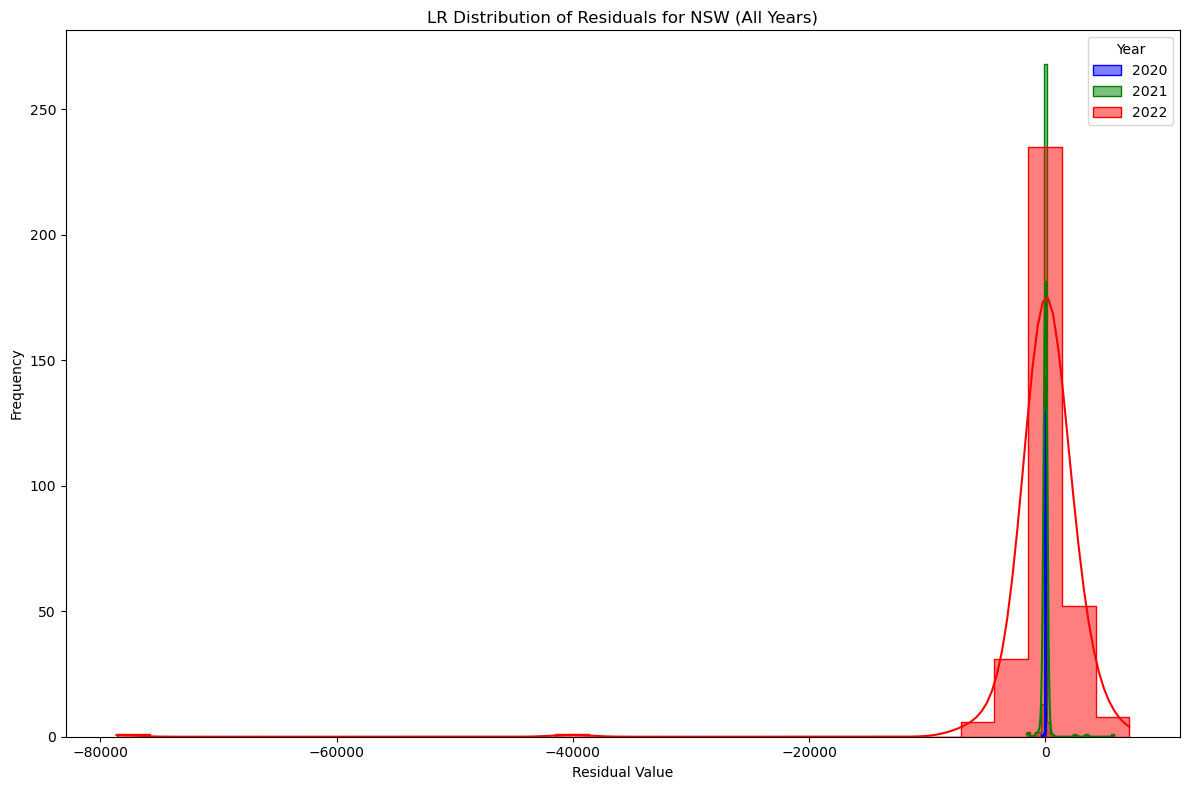

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("nswdata.csv")

# Convert date format for model
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Define features
features = [
    "cases_diff", "total_cases", "daily_doses", "total_doses", "lockdown_level",
    "hospitalised", "icu", "vent", "daily_deaths", "deaths", "pcr_tests", "temp_celc",
    "schools_closed", "restaurants_closed", "home_gatherings", "outdoor_gatherings",
    "masks_mandate", "international_travel"
]

# Create arrays to store results for all years
all_y_test = []
all_y_pred = []
all_years = []
all_test_dates = []

# Set window size to 30 
window_size = 30

for year in [2020, 2021, 2022]:
    print(f"Results for year: {year}")
    df_year = df[df['date'].dt.year == year]

    X = df_year[features]
    y = df_year["daily_cases"]

    yearly_y_test = []
    yearly_y_pred = []

    # Sliding Window Loop
    for start in range(0, len(df_year) - window_size - 1):
        train = df_year[start:start + window_size]
        test = df_year[start + window_size:start + window_size + 1]
        
        X_train = train[features]
        y_train = train["daily_cases"]
        
        X_test = test[features]
        y_test = test["daily_cases"]
        
        test_date = test['date'].values[0]
        all_test_dates.append(test_date)

        # Train 
        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)
        
        # Predict
        y_pred = linear_model.predict(X_test)

        yearly_y_test.append(y_test.values[0])
        yearly_y_pred.append(y_pred[0])

    # Add results for the current year to the total results
    all_y_test.extend(yearly_y_test)
    all_y_pred.extend(yearly_y_pred)
    all_years.append(year)

    mse = mean_squared_error(yearly_y_test, yearly_y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yearly_y_test, yearly_y_pred)
    r2 = r2_score(yearly_y_test, yearly_y_pred)
    avg_daily_cases = df_year["daily_cases"].mean()

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print(f"Average Daily Cases for {year}: {avg_daily_cases:.2f}")

    # Actual vs. Predicted Daily Cases Plot
    plt.figure(figsize=(14, 8))
    test_dates = df_year['date'][window_size:window_size+len(yearly_y_pred)]
    plt.plot(test_dates, yearly_y_test, 'o-', label='Actual Daily Cases')
    plt.plot(test_dates, yearly_y_pred, 's-', label='Predicted Daily Cases')
    plt.title(f'LR Actual vs. Predicted Daily Cases for NSW {year}')
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Residuals vs. Predicted Scatter Plot
    residuals = np.array(yearly_y_test) - np.array(yearly_y_pred)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=yearly_y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel('Predicted Daily Cases')
    plt.ylabel('Residuals')
    plt.title(f'LR Residuals vs. Predicted Daily Cases for NSW {year}')
    plt.tight_layout()
    plt.show()

    # Distribution of Residuals Histogram
    plt.figure(figsize=(12, 8))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'LR Distribution of Residuals for NSW {year}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Actual vs. Predicted Daily Cases for All Years 
plt.figure(figsize=(14, 8))
plt.plot(all_test_dates, all_y_test, 'o-', label='Actual Daily Cases')
plt.plot(all_test_dates, all_y_pred, 's-', label='Predicted Daily Cases')
plt.title('LR Actual vs. Predicted Daily Cases for NSW (All Years)')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residuals for All Years Scatter Plot
plt.figure(figsize=(12, 8))
sort_indices = np.argsort(all_test_dates)
all_test_dates = np.array(all_test_dates)[sort_indices]
all_y_test = np.array(all_y_test)[sort_indices]
all_y_pred = np.array(all_y_pred)[sort_indices]
residuals_all = all_y_test - all_y_pred
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'} 
sns.scatterplot(x=all_y_pred, 
                y=residuals_all, 
                hue=pd.to_datetime(all_test_dates).year.astype(str),  
                palette=palette, 
                legend="full")
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Daily Cases')
plt.ylabel('Residuals')
plt.title('LR Residuals vs. Predicted Daily Cases for NSW (All Years)')
plt.legend(title="Year")
plt.tight_layout()
plt.show()


# Distribution of Residuals for All Years
plt.figure(figsize=(12, 8))
residuals_df = pd.DataFrame({
    'Residuals': all_y_test - all_y_pred,
    'Year': pd.to_datetime(all_test_dates).year.astype(str) 
})
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'}
for year, color in palette.items():
    sns.histplot(data=residuals_df[residuals_df['Year'] == year], 
                 x='Residuals', 
                 kde=True, 
                 color=color, 
                 element="step", 
                 bins=30, 
                 common_norm=False,  
                 label=f'{year}')
plt.title('LR Distribution of Residuals for NSW (All Years)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend(title='Year')  
plt.tight_layout()
plt.show()

Results for year: 2020
MSE: 1518.469737194335
RMSE: 38.967547230924545
MAE: 17.092254567182284
R2 Score: 0.9159734765439623
Average Daily Cases for 2020: 64.21


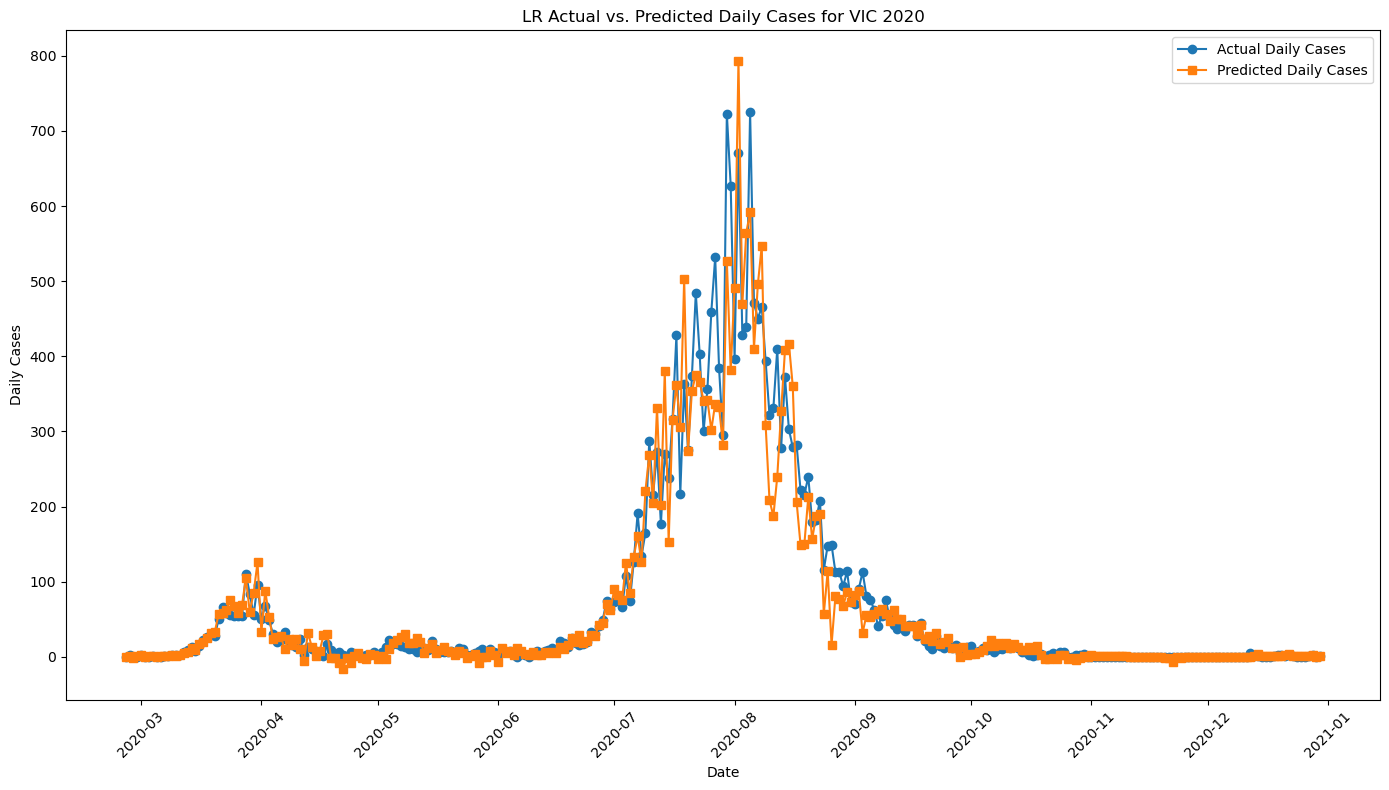

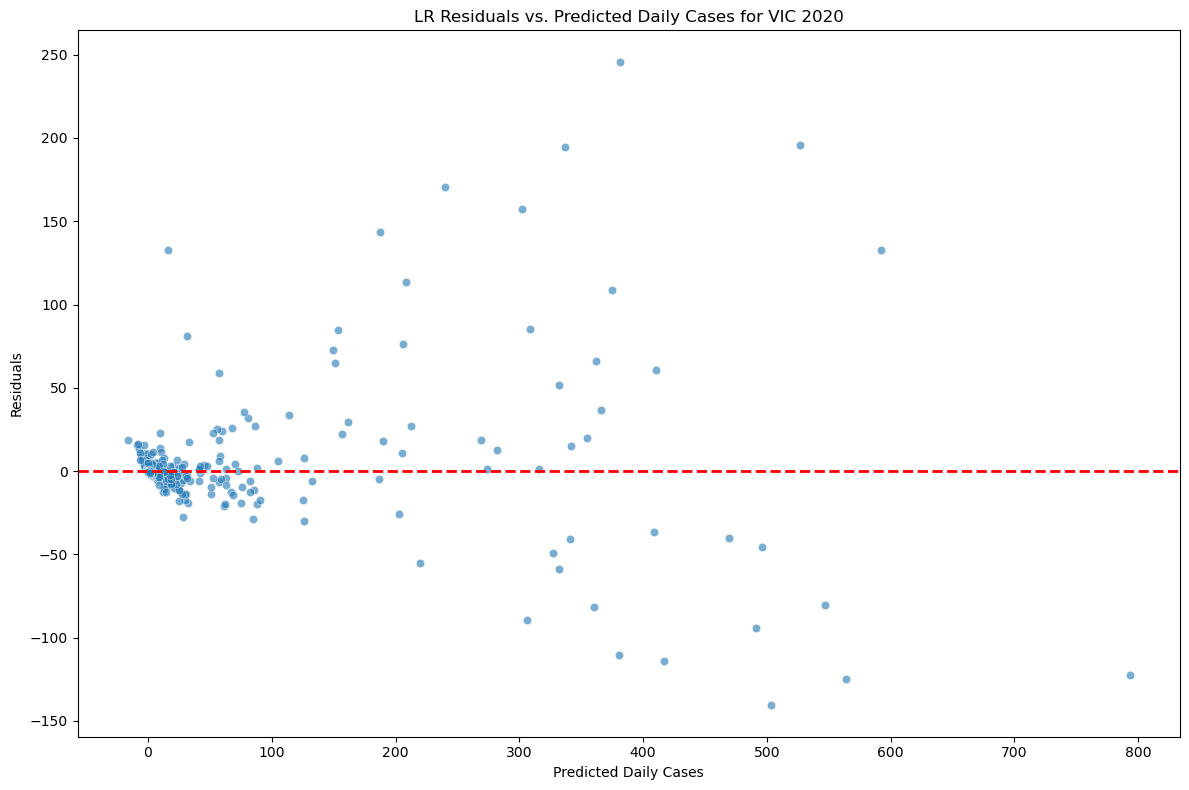

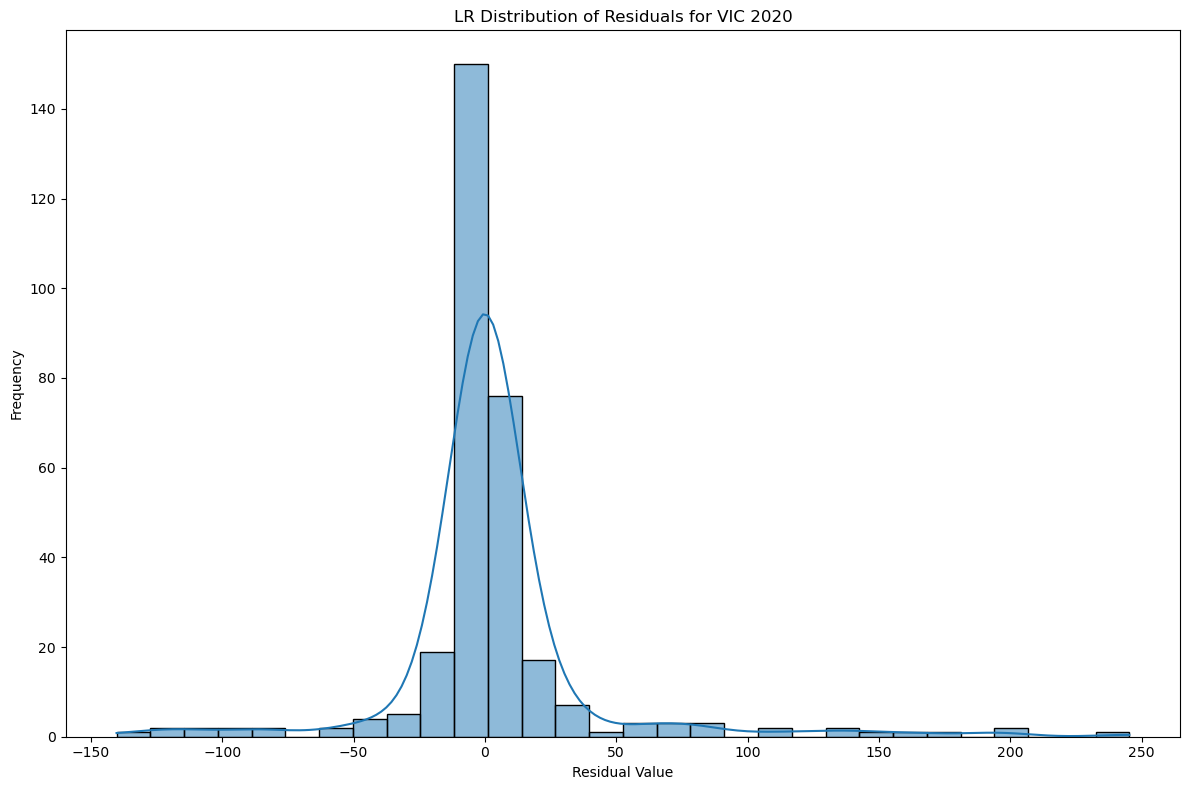

Results for year: 2021
MSE: 239619.13936235415
RMSE: 489.5090799590485
MAE: 94.87445974288747
R2 Score: 0.5442041755737612
Average Daily Cases for 2021: 435.41


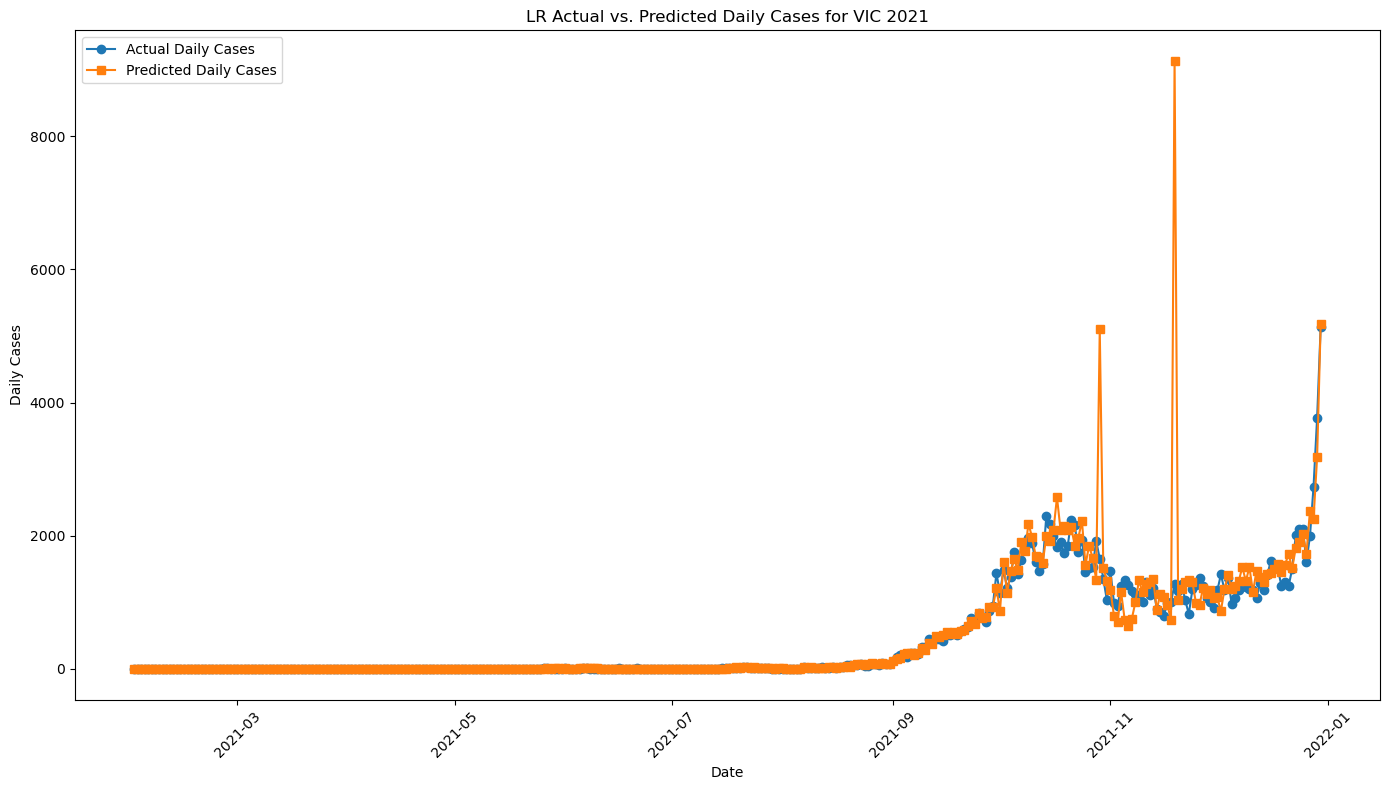

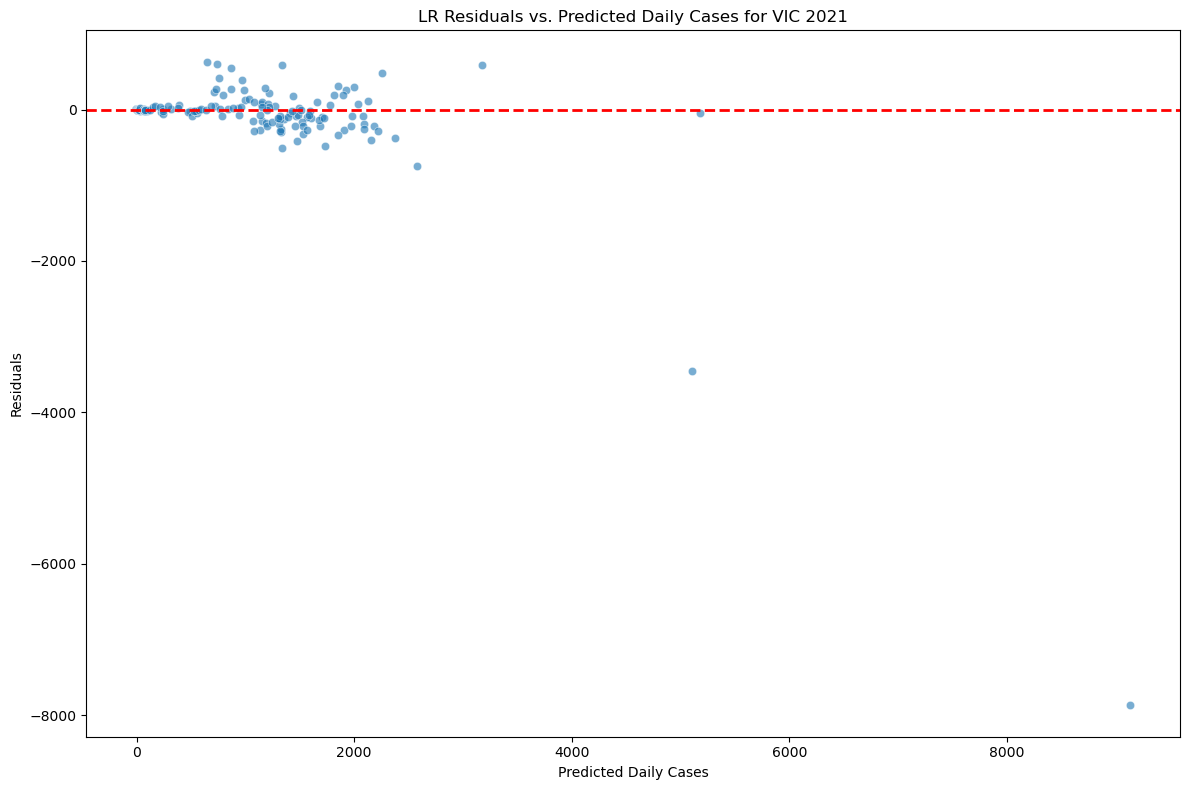

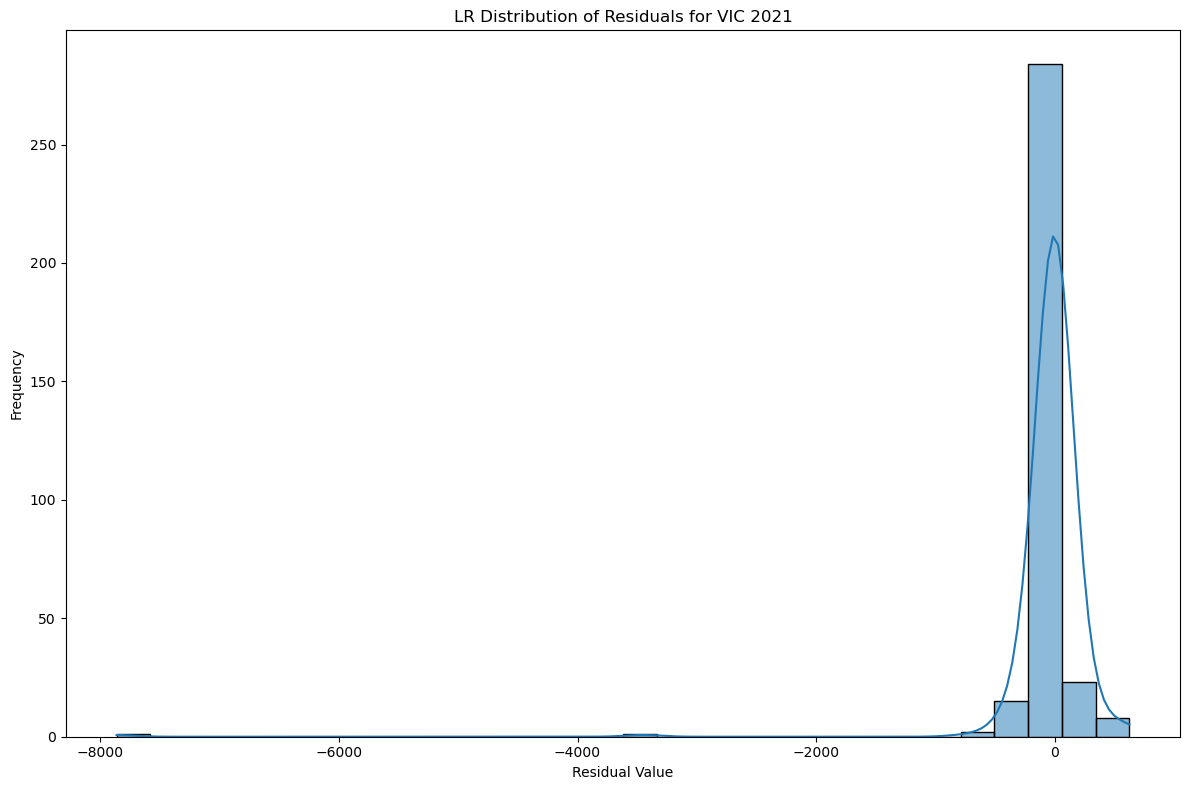

Results for year: 2022
MSE: 2112957.3160646586
RMSE: 1453.6014983703953
MAE: 1099.0956526992059
R2 Score: 0.7495990400143862
Average Daily Cases for 2022: 9840.10


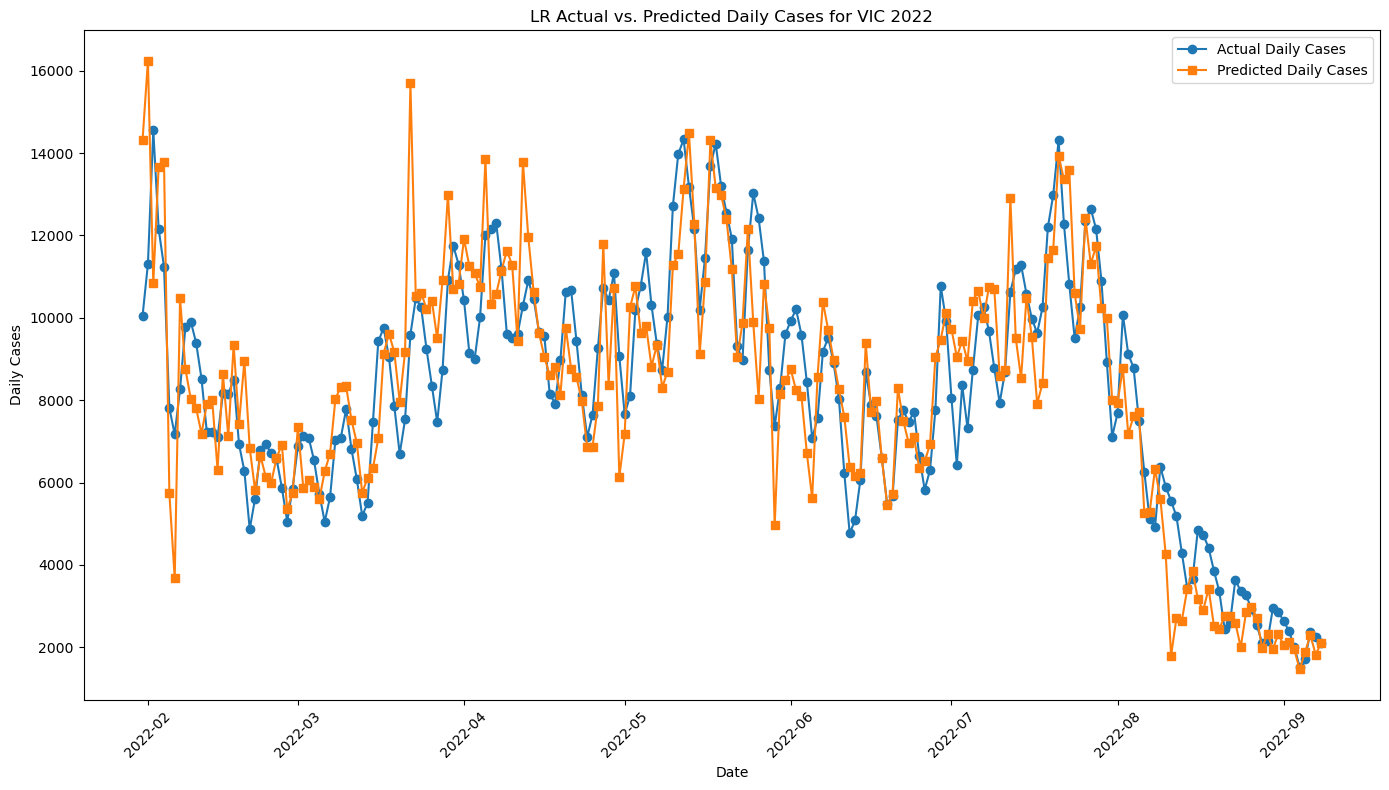

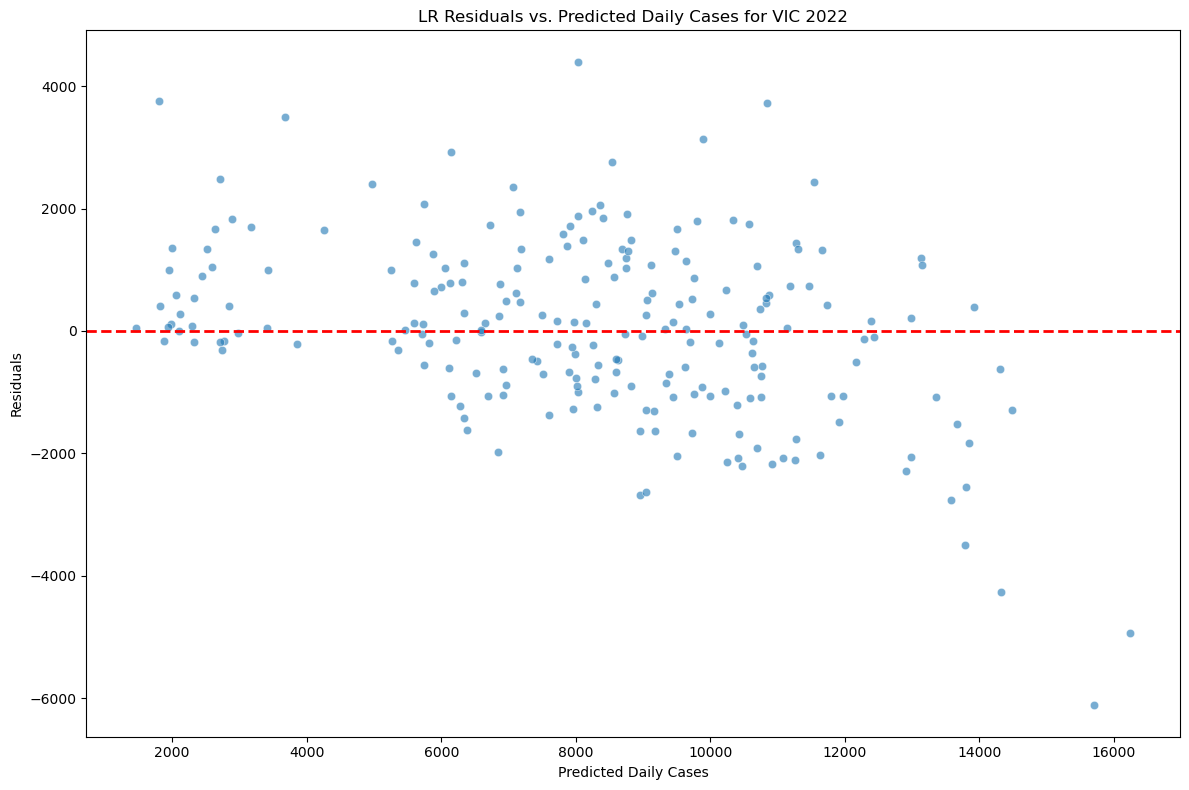

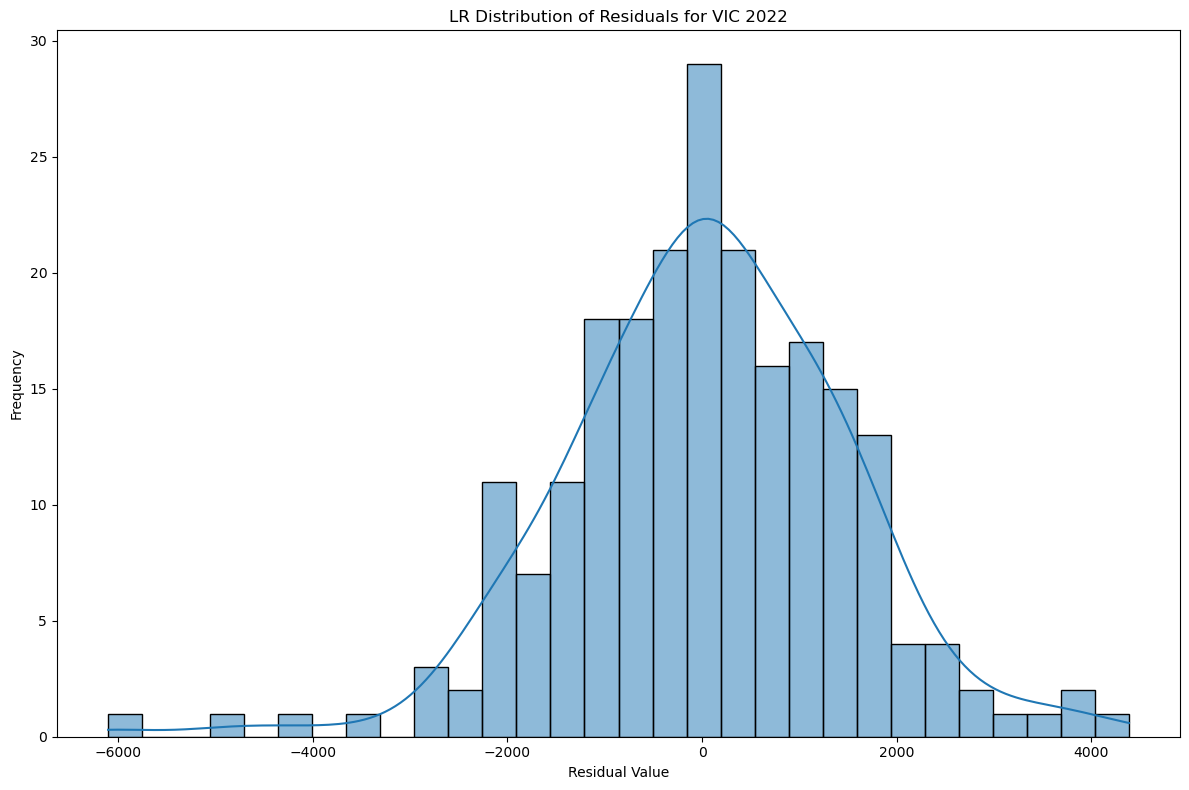

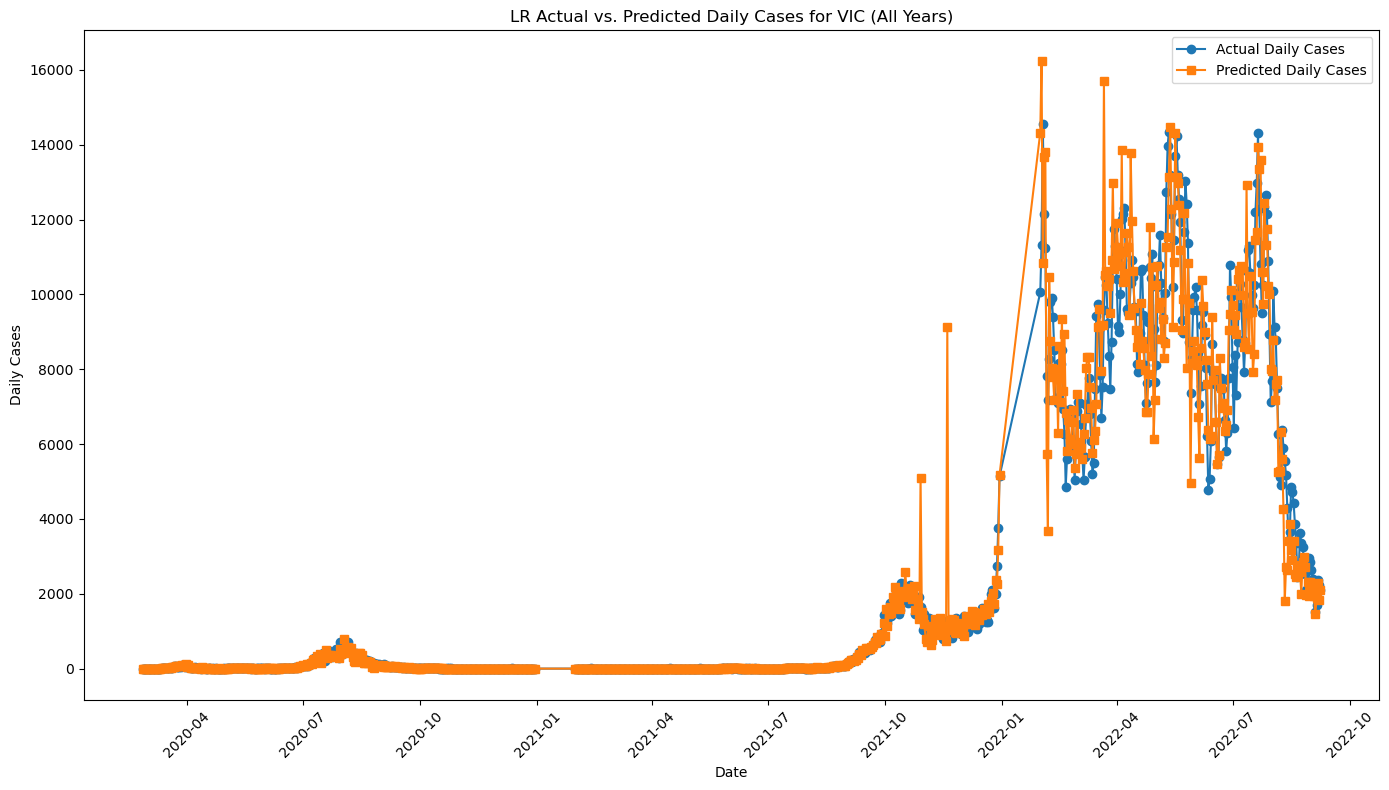

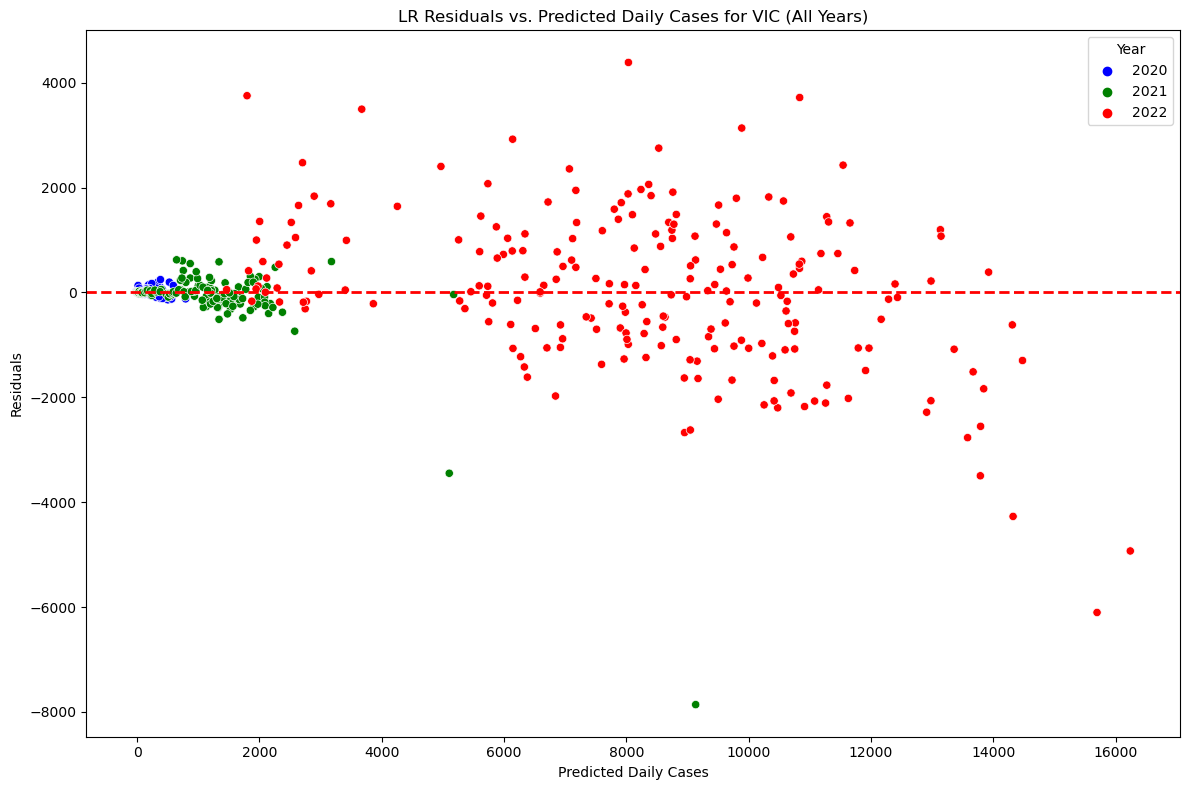

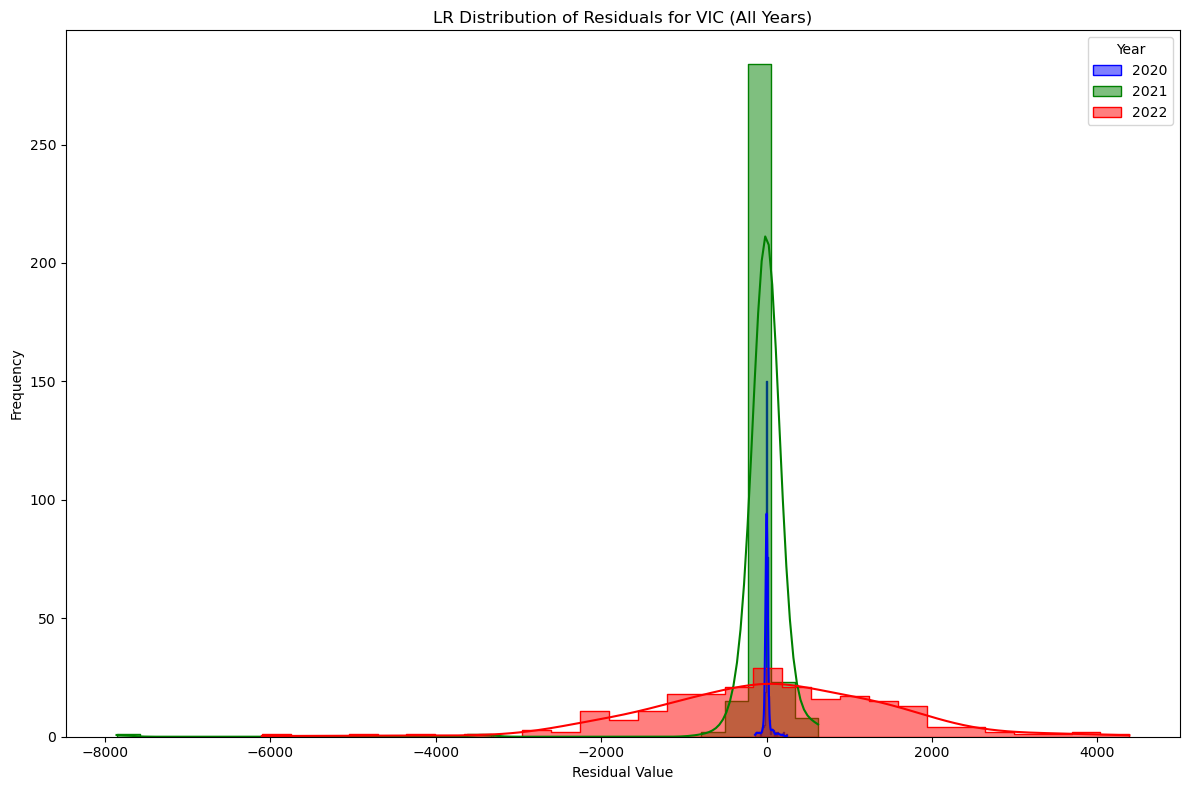

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("vicdata.csv")

# Convert date format for model
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Define features
features = [
    "cases_diff", "total_cases", "daily_doses", "total_doses", "lockdown_level",
    "hospitalised", "icu", "vent", "daily_deaths", "deaths", "pcr_tests", "temp_celc",
    "schools_closed", "restaurants_closed", "home_gatherings", "outdoor_gatherings",
    "masks_mandate", "international_travel"
]

# Create arrays to store results for all years
all_y_test = []
all_y_pred = []
all_years = []
all_test_dates = []

# Set window size to 30 
window_size = 30

for year in [2020, 2021, 2022]:
    print(f"Results for year: {year}")
    df_year = df[df['date'].dt.year == year]

    X = df_year[features]
    y = df_year["daily_cases"]

    yearly_y_test = []
    yearly_y_pred = []

    # Sliding Window Loop
    for start in range(0, len(df_year) - window_size - 1):
        train = df_year[start:start + window_size]
        test = df_year[start + window_size:start + window_size + 1]
        
        X_train = train[features]
        y_train = train["daily_cases"]
        
        X_test = test[features]
        y_test = test["daily_cases"]
        
        test_date = test['date'].values[0]
        all_test_dates.append(test_date)

        # Train 
        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)

        # Predict
        y_pred = linear_model.predict(X_test)

        yearly_y_test.append(y_test.values[0])
        yearly_y_pred.append(y_pred[0])

    # Add results for the current year to the total results
    all_y_test.extend(yearly_y_test)
    all_y_pred.extend(yearly_y_pred)
    all_years.append(year)

    mse = mean_squared_error(yearly_y_test, yearly_y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yearly_y_test, yearly_y_pred)
    r2 = r2_score(yearly_y_test, yearly_y_pred)
    avg_daily_cases = df_year["daily_cases"].mean()

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print(f"Average Daily Cases for {year}: {avg_daily_cases:.2f}")

    # Actual vs. Predicted Daily Cases Plot
    plt.figure(figsize=(14, 8))
    test_dates = df_year['date'][window_size:window_size+len(yearly_y_pred)]
    plt.plot(test_dates, yearly_y_test, 'o-', label='Actual Daily Cases')
    plt.plot(test_dates, yearly_y_pred, 's-', label='Predicted Daily Cases')
    plt.title(f'LR Actual vs. Predicted Daily Cases for VIC {year}')
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Residuals vs. Predicted Scatter Plot
    residuals = np.array(yearly_y_test) - np.array(yearly_y_pred)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=yearly_y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel('Predicted Daily Cases')
    plt.ylabel('Residuals')
    plt.title(f'LR Residuals vs. Predicted Daily Cases for VIC {year}')
    plt.tight_layout()
    plt.show()

    # Distribution of Residuals Histogram
    plt.figure(figsize=(12, 8))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'LR Distribution of Residuals for VIC {year}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Actual vs. Predicted Daily Cases for All Years 
plt.figure(figsize=(14, 8))
plt.plot(all_test_dates, all_y_test, 'o-', label='Actual Daily Cases')
plt.plot(all_test_dates, all_y_pred, 's-', label='Predicted Daily Cases')
plt.title('LR Actual vs. Predicted Daily Cases for VIC (All Years)')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residuals for All Years Scatter Plot
plt.figure(figsize=(12, 8))
sort_indices = np.argsort(all_test_dates)
all_test_dates = np.array(all_test_dates)[sort_indices]
all_y_test = np.array(all_y_test)[sort_indices]
all_y_pred = np.array(all_y_pred)[sort_indices]
residuals_all = all_y_test - all_y_pred
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'} 
sns.scatterplot(x=all_y_pred, 
                y=residuals_all, 
                hue=pd.to_datetime(all_test_dates).year.astype(str), 
                palette=palette,  
                legend="full")
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Daily Cases')
plt.ylabel('Residuals')
plt.title('LR Residuals vs. Predicted Daily Cases for VIC (All Years)')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

# Distribution of Residuals for All Years
plt.figure(figsize=(12, 8))
residuals_df = pd.DataFrame({
    'Residuals': all_y_test - all_y_pred,
    'Year': pd.to_datetime(all_test_dates).year.astype(str) 
})
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'}
for year, color in palette.items():
    sns.histplot(data=residuals_df[residuals_df['Year'] == year], 
                 x='Residuals', 
                 kde=True, 
                 color=color, 
                 element="step", 
                 bins=30, 
                 common_norm=False,  
                 label=f'{year}') 
plt.title('LR Distribution of Residuals for VIC (All Years)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend(title='Year') 
plt.tight_layout()
plt.show()

